<a href="https://www.kaggle.com/code/pranavjha24/churn-prediction-tackling-data-imbalance?scriptVersionId=189755074" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


<h3 style='color:blue' align='center'>Customer Churn Prediction Using Artificial Neural Network (ANN)</h3>

Customer churn prediction involves identifying the reasons why customers are leaving a business. We'll develop a deep learning model to predict churn and evaluate its performance using precision, recall, and F1-score metrics.








In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Load the Data

In [4]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.Churn.value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [6]:
517400/df.shape[0]

73.46301292063042

**First of all, drop customerID column as it is of no use**

In [7]:
df.drop('customerID',axis='columns',inplace=True)
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Quick glance at above makes me realize that TotalCharges should be float but it is an object. Let's check what's going on with  this column**

In [8]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

**Some values seems to be not numbers but blank string. Let's find out such rows**

In [9]:
pd.to_numeric(df.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [10]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [11]:
df.shape

(7043, 20)

In [12]:
df.iloc[488].TotalCharges

' '

In [13]:
df[df.TotalCharges!=' '].shape

(7032, 20)

**Remove rows with space in TotalCharges**

In [14]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [15]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [16]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

In [17]:
df1.TotalCharges.dtypes

dtype('float64')

In [18]:
df1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [19]:
df1[df1.Churn=='No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


**Data Visualization**

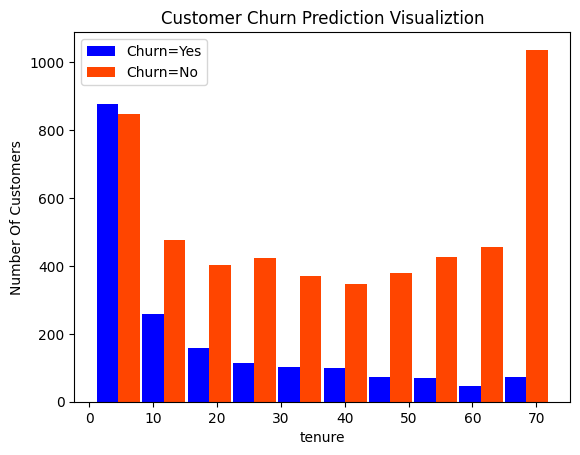

In [20]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['blue','orangered'],label=['Churn=Yes','Churn=No'])
plt.legend()

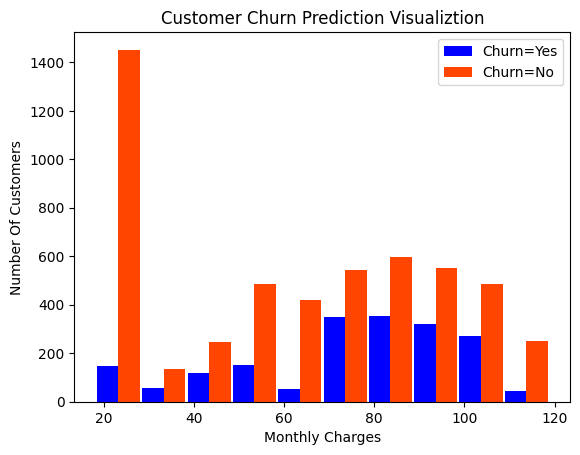

In [21]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges      
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['blue','orangered'],label=['Churn=Yes','Churn=No'])
plt.legend()

**Many of the columns are yes, no etc. Let's print unique values in object columns to see data values**

In [22]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

In [23]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**

In [24]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

In [25]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Convert Yes and No to 1 or 0**

In [26]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

In [27]:
for col in df1:
    print(f'{col}: {df1[col].unique()}') 

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [28]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

In [29]:
df1.gender.unique()

array([1, 0])

In [30]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [31]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No             

**Train test split**

In [32]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [33]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

**Train test split**

In [34]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [35]:
y_train.value_counts()

Churn
0    4164
1    1461
Name: count, dtype: int64

In [36]:
y.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [37]:
y_test.value_counts()

Churn
0    999
1    408
Name: count, dtype: int64

In [38]:
X_train.shape

(5625, 26)

In [39]:
X_test.shape

(1407, 26)

In [40]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,...,False,True,False,True,False,False,False,True,False,False
101,1,0,1,1,0.000000,1,0,0,0,0,...,False,False,True,True,False,False,False,False,True,False
2621,0,0,1,0,0.985915,1,0,0,1,1,...,True,False,False,False,False,True,False,True,False,False
392,1,1,0,0,0.014085,1,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
1327,0,0,1,0,0.816901,1,1,0,0,1,...,False,True,False,False,True,False,True,False,False,False
3607,1,0,0,0,0.169014,1,0,1,0,0,...,True,False,False,False,True,False,False,False,False,True
2773,0,0,1,0,0.323944,0,0,0,0,1,...,True,False,False,True,False,False,False,False,True,False
1936,1,0,1,0,0.704225,1,0,1,1,0,...,True,False,False,False,True,False,True,False,False,False
5387,0,0,0,0,0.042254,0,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
4331,0,0,0,0,0.985915,1,1,0,0,0,...,False,False,True,False,False,True,True,False,False,False


In [41]:
len(X_train.columns)

26

**Build a model (ANN) in tensorflow/keras**

In [42]:
# !pip install -U tensorflow-addons
# !pip install tensorflow==2.12
# !pip install tensorflow-addons==0.23.0 numpy<1.26 typeguard<5

# from tensorflow_addons import losses

In [43]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report

2024-07-25 15:53:21.447999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 15:53:21.448152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 15:53:21.622849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [44]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

In [45]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6862 - loss: 0.5617
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7946 - loss: 0.4324
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4286
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8094 - loss: 0.4027
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8099 - loss: 0.4074
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8099 - loss: 0.4065
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8136 - loss: 0.4050
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.4125
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.4132
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8116 - loss: 0.4022
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4091
Epoch 12/100
176/176 ━━━━━━━━━━━━━━━━━━━━

## Mitigating Skewdness of Data

### Method 1: Undersampling

In [46]:
# Class count
count_class_0, count_class_1 = df1.Churn.value_counts()

# Divide by class
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]

In [47]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
Churn
0    1869
1    1869
Name: count, dtype: int64


In [48]:
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [49]:
# Number of classes in training Data
y_train.value_counts()

Churn
0    1495
1    1495
Name: count, dtype: int64

**Printing Classification in the last, Scroll down till the last epoch to watch the classification report**

In [50]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5680 - loss: 0.6606
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7525 - loss: 0.5560
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.4805
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7736 - loss: 0.4849
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7651 - loss: 0.4808
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.4519
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.4790
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7749 - loss: 0.4624
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7794 - loss: 0.4556
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.4714
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7819 - loss: 0.4534
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

### Method2: Oversampling

In [51]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
Churn
0    5163
1    5163
Name: count, dtype: int64


In [52]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [53]:
# Number of classes in training Data
y_train.value_counts()

Churn
1    4130
0    4130
Name: count, dtype: int64

In [54]:
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6788 - loss: 0.5978
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7612 - loss: 0.4924
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7621 - loss: 0.4845
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7695 - loss: 0.4747
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7733 - loss: 0.4678
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7692 - loss: 0.4754
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7703 - loss: 0.4641
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7747 - loss: 0.4703
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7765 - loss: 0.4559
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7715 - loss: 0.4675
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.4528
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━

### Method3: SMOTE

To install imbalanced-learn library use **pip install imbalanced-learn** command

In [55]:
!pip install imbalanced-learn
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

Churn
0    5163
1    5163
Name: count, dtype: int64

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [58]:
# Number of classes in training Data
y_train.value_counts()

Churn
1    4130
0    4130
Name: count, dtype: int64

In [59]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6183 - loss: 0.6357
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.4745
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7750 - loss: 0.4651
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.4544
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.4502
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7922 - loss: 0.4432
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.4462
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7875 - loss: 0.4484
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7943 - loss: 0.4444
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8109 - loss: 0.4227
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.4288
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━

### Method4: Use of Ensemble with undersampling

In [60]:
df2.Churn.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [61]:
# Regain Original features and labels
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [63]:
y_train.value_counts()

Churn
0    4130
1    1495
Name: count, dtype: int64

model1 --> class1(1495) + class0(0, 1495)

model2 --> class1(1495) + class0(1496, 2990)

model3 --> class1(1495) + class0(2990, 4130)

In [64]:
df3 = X_train.copy()
df3['Churn'] = y_train

In [65]:
df3.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
684,1,0,0,0,0.000000,1,0,0,0,0,...,True,False,True,False,False,False,False,False,True,0
2446,1,0,0,0,0.239437,1,1,0,1,0,...,True,False,True,False,False,False,True,False,False,1
1680,0,0,1,1,0.774648,1,1,0,0,0,...,False,True,False,True,False,False,False,False,True,0
2220,0,0,1,0,1.000000,1,0,1,1,0,...,False,False,False,False,True,True,False,False,False,0
2842,1,0,0,0,0.042254,0,0,1,0,1,...,False,False,True,False,False,False,False,False,True,0


In [66]:
df3_class0 = df3[df3.Churn==0]
df3_class1 = df3[df3.Churn==1]

In [67]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train   

In [68]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 0, 1495)

y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6911 - loss: 0.6127
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7396 - loss: 0.5387
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.4740
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7703 - loss: 0.4831
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7578 - loss: 0.5041
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7639 - loss: 0.4882
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.4743
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7643 - loss: 0.4936
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7853 - loss: 0.4624
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7560 - loss: 0.4828
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7893 - loss: 0.4646
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [69]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 1495, 2990)

y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6208 - loss: 0.6541
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7498 - loss: 0.5184
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7481 - loss: 0.5051
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7625 - loss: 0.4850
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7666 - loss: 0.4772
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7536 - loss: 0.4978
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7642 - loss: 0.4818
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7689 - loss: 0.4742
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7565 - loss: 0.4933
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - loss: 0.4587
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7683 - loss: 0.4809
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [70]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 2990, 4130)

y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5713 - loss: 0.6674
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7752 - loss: 0.5023
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7709 - loss: 0.4823
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - loss: 0.4689
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7933 - loss: 0.4628
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.4639
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7824 - loss: 0.4736
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7746 - loss: 0.4766
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.4936
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7637 - loss: 0.4882
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7857 - loss: 0.4722
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [71]:
len(y_pred1)

1407

In [72]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [73]:
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1033
           1       0.48      0.75      0.59       374

    accuracy                           0.72      1407
   macro avg       0.68      0.73      0.69      1407
weighted avg       0.78      0.72      0.73      1407

